In [1]:
import cv2,os

data_path=r"C:\Users\ayush\Desktop\last(2)"
categories=os.listdir(data_path)
labels=[i for i in range(len(categories))]

label_dict=dict(zip(categories,labels)) #empty dictionary

print(label_dict)
print(categories)
print(labels)

{'without_mask': 0, 'with_mask': 1}
['without_mask', 'with_mask']
[0, 1]


In [2]:
img_size=100
data=[]
target=[]


for category in categories:
    folder_path=os.path.join(data_path,category)
    img_names=os.listdir(folder_path)
        
    for img_name in img_names:
        img_path=os.path.join(folder_path,img_name)
        img=cv2.imread(img_path)

        try:
            gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)           
            #Coverting the image into gray scale
            resized=cv2.resize(gray,(img_size,img_size))
            #resizing the gray scale into 50x50, since we need a fixed common size for all the images in the dataset
            data.append(resized)
            target.append(label_dict[category])
            #appending the image and the label(categorized) into the list (dataset)

        except Exception as e:
            print('Exception:',e)
            #if any exception rasied, the exception will be printed here. And pass to the next image

In [3]:
import numpy as np

data=np.array(data)/255.0
data=np.reshape(data,(data.shape[0],img_size,img_size,1))
target=np.array(target)

from keras.utils import np_utils

new_target=np_utils.to_categorical(target)

In [4]:
np.save('data',data)
np.save('target',new_target)

In [5]:
import numpy as np

data=np.load('data.npy')
target=np.load('target.npy')


In [25]:
from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten,Dropout
from keras.layers import Conv2D,MaxPooling2D
from keras.callbacks import ModelCheckpoint

model=Sequential()

model.add(Conv2D(200,(3,3),input_shape=data.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))
#The first CNN layer followed by Relu and MaxPooling layers

model.add(Conv2D(100,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))
#The second convolution layer followed by Relu and MaxPooling layers

model.add(Flatten())
model.add(Dropout(0.5))
#Flatten layer to stack the output convolutions from second convolution layer
model.add(Dense(50,activation='relu'))
#Dense layer of 64 neurons
model.add(Dense(2,activation='softmax'))
#The Final layer with two outputs for two categories

model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [26]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 98, 98, 200)       2000      
_________________________________________________________________
activation_4 (Activation)    (None, 98, 98, 200)       0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 49, 49, 200)       0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 49, 49, 200)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 47, 47, 100)       180100    
_________________________________________________________________
activation_5 (Activation)    (None, 47, 47, 100)       0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 23, 23, 100)      

In [27]:
print(len(model.layers))

12


In [8]:
from sklearn.model_selection import train_test_split

train_data,test_data,train_target,test_target=train_test_split(data,target,test_size=0.1)

In [9]:
checkpoint = ModelCheckpoint('model-{epoch:03d}.model',monitor='val_loss',verbose=0,save_best_only=True,mode='auto')
history=model.fit(train_data,train_target,epochs=50,callbacks=[checkpoint],validation_split=0.2)


Epoch 1/50
22/22 [==============================] - ETA: 0s - loss: 0.7619 - accuracy: 0.5851WARNING:tensorflow:From c:\users\ayush\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\ops\resource_variable_ops.py:1817: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: model-001.model\assets
22/22 [==============================] - 25s 1s/step - loss: 0.7619 - accuracy: 0.5851 - val_loss: 0.4304 - val_accuracy: 0.7943
Epoch 2/50
22/22 [==============================] - 25s 1s/step - loss: 0.3909 - accuracy: 0.8283 - val_loss: 0.3440 - val_accuracy: 0.8514
Epoch 3/50
22/22 [==============================] - 24s 1s/step - loss: 0.2681 - accuracy: 0.8798 - val_loss: 0.2711 - val_accuracy: 0.8857
Epoch 4/50
22/22 [==============================] 

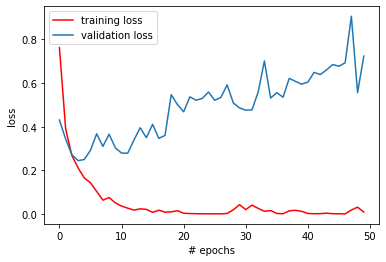

In [10]:
from matplotlib import pyplot as plt

plt.plot(history.history['loss'],'r',label='training loss')
plt.plot(history.history['val_loss'],label='validation loss')
plt.xlabel('# epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

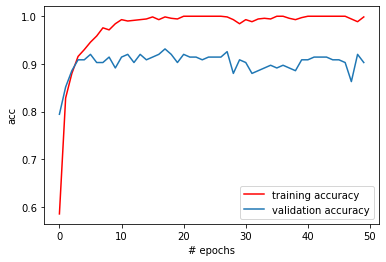

In [11]:
plt.plot(history.history['accuracy'],'r',label='training accuracy')
plt.plot(history.history['val_accuracy'],label='validation accuracy')
plt.xlabel('# epochs')
plt.ylabel('acc')
plt.legend()
plt.show()

In [12]:
print(model.evaluate(test_data,test_target))

4/4 [==============================] - 0s 111ms/step - loss: 0.7022 - accuracy: 0.8878
[0.7022186517715454, 0.8877550959587097]


In [13]:
from keras.models import load_model
import cv2
import numpy as np

In [14]:
model.save("model-047.model")

INFO:tensorflow:Assets written to: model-047.model\assets


In [21]:
model = load_model('model-047.model')

face_clsfr=cv2.CascadeClassifier(r'C:\Users\ayush\Desktop\internship_project\haarcascade_frontalface_default.xml')

source=cv2.VideoCapture(0)

labels_dict={0:'MASK',1:'NOMASK'}
color_dict={0:(0,255,0),1:(0,0,255)}
while(True):

    ret,img=source.read()
    gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    faces=face_clsfr.detectMultiScale(gray,1.3,5)  

    for (x,y,w,h) in faces:
    
        face_img=gray[y:y+w,x:x+w]
        resized=cv2.resize(face_img,(100,100))
        normalized=resized/255.0
        reshaped=np.reshape(normalized,(1,100,100,1))
        result=model.predict(reshaped)

        label=np.argmax(result,axis=1)[0]
        acc=round(np.max(result,axis=1)[0]*100,2)
      
        cv2.rectangle(img,(x,y),(x+w,y+h),color_dict[label],2)
        cv2.rectangle(img,(x,y-40),(x+w,y),color_dict[label],-1)
        cv2.putText(img, labels_dict[label], (x, y-10),cv2.FONT_HERSHEY_SIMPLEX,0.8,(255,255,255),2)
        cv2.putText(img,str(acc),(x+150,y-10),cv2.FONT_HERSHEY_SIMPLEX,0.8,(255,255,255),2)
        cv2.putText(img,labels_dict[label],(x,y-10),cv2.FONT_HERSHEY_SIMPLEX,0.8,(255,255,255),2)
        
        
        
    cv2.imshow('LIVE',img)
    key=cv2.waitKey(1)
    
    if(key==27):
        break
        
cv2.destroyAllWindows()
source.release()

